# Using DirectView and LoadBalancedView together

We mentioned that you can use any number of views of any sort simultaneously.

The most common model for doing this is to use a DirectView to initialise the engine namespaces
(either defining functions and variables, or loading datasets) with a DirectView,
and then submitting work as tasks via the LoadBalancedView.

For this example, we are going to define a few functions for fetching data and getting a simple summary on some stocks,
then we are going to run those functions on a series of stocks in a load-balanced way.

The usual boilerplate:

In [1]:
%pylab inline


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


In [2]:
from IPython import parallel

rc = parallel.Client()
dv = rc[:]
lbv = rc.load_balanced_view()

Use matplotlib to fetch data from Yahoo

Note that we are defining these functions on the engines

In [3]:
%%px

import urllib2
from io import BytesIO

from matplotlib import finance

def get_yahoo_data(name=None, start=None, end=None):
    """return historical stock data from yahoo as a recarray."""
    fp = finance.fetch_historical_yahoo(name, start, end)
    return finance.parse_yahoo_historical(fp, asobject=True)

def relative_close(records):
    """return the reative change in closing price over the interval"""
    
    close = records['aclose']
    return (close[-1] - close[0]) / close[0]



Setup the timestamps.  We want the past year

In [4]:
%%px
import datetime
end = datetime.datetime.now()
start = end - datetime.timedelta(days=365)

Our ticker of stocks to check

In [5]:
ticker = ['AAPL', 'GOOG', 'MSFT', 'RIMM', 'NOK', 'ORCL', 'AMZN', 'INTC', 'ATVI', 'EA', 'NFLX']

And map a simple function (that depends on the code we have defined on the engines)
onto our ticker.

In [6]:
def year_over_year(name):
    """fetch data, and return year-over-year change (relative to first close)
 
    in percent
    """
    stock = get_yahoo_data(name, start, end)
    return relative_close(stock) * 100

amr = lbv.map(year_over_year, ticker)
amr

<AsyncMapResult: year_over_year>

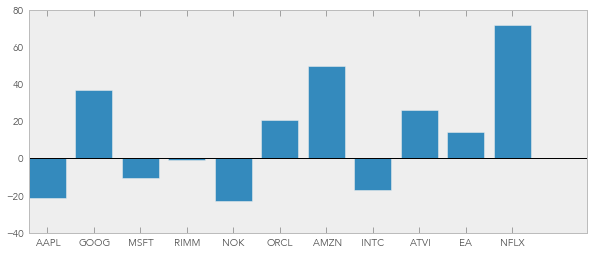

In [7]:
fig, ax = subplots()
fig.set_figwidth(10)
ax.bar(range(len(amr)), amr)
ax.set_xticks(np.arange(len(amr))+0.4)
ax.set_xticklabels(ticker);
ax.axhline(0, c='k')